### Visusalizing concepts leared by CPM with CEBaB
Our Causal Proxy Model (CPM) has localized information about different concepts. This documents tries to visualize this `localization` efforts of CPM. We plot whether CPM learns clustered representations for different concepts.

**Note**: We actually decided not to include this study into the paper as we later found out that there is no reason to hypothesize that representations are clustered "more" with CPM, since different slices of representations can naturally have different numeric value distribution.

In [1]:
from libs import *
from modelings.modelings_bert import *
from modelings.modelings_roberta import *
from modelings.modelings_gpt2 import *
from modelings.modelings_lstm import *

"""
For evaluate, we use a single random seed, as
the models are trained with 5 different seeds
already.
"""
_ = random.seed(123)
_ = np.random.seed(123)
_ = torch.manual_seed(123)

In [2]:
"""
The following blocks will run CEBaB benchmark in
all the combinations of the following conditions.
"""
grid = {
    "eval_split": ["test"],
    # dev,test
    "control": ["ks"],
    # baseline-random,baseline-blackbox,hdims,layers,ks,approximate,ablation
    "seed": [42],
    # 42, 66, 77
    "h_dim": [192],
    # 1,16,64,128,192
    # 1,16,64,75
    "interchange_layer" : [10],
    # 0,1; 2,4,6,8,10,12
    "class_num": [5],
    "k" : [19684], 
    # 0;10,100,500,1000,3000,6000,9848,19684
    "alpha" : [1.0],
    # 0.0,1.0
    "beta" : [1.0],
    # 0.0,1.0
    "gemma" : [3.0],
    # 0.0,3.0
    "model_arch" : ["bert-base-uncased"],
    # lstm, bert-base-uncased, roberta-base, gpt2
    "lr" : ["8e-05"],
    # 8e-05; 0.001
    "counterfactual_type" : ["true"]
    # approximate,true
}

keys, values = zip(*grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

device = 'cuda:6'
batch_size = 32

if grid["control"][0] == "hdims" or grid["control"][0] == "layers":
    assert grid["eval_split"][0] == "dev"
else:
    assert grid["eval_split"][0] == "test"
    
aspect_label_encode = {
    "Negative":0,
    "Positive":1,
    "unknown":2,
    "no majority": 2,
}

In [29]:
def fetch_reprs(explainer, test, control=False):

    # put it into eval() mode.
    explainer.cpm_model.model.eval()
    explainer.blackbox_model.eval()
    
    interchange_layer = explainer.cpm_model.model.config.interchange_hidden_layer
    h_dim = explainer.cpm_model.model.config.intervention_h_dim
    aspects = ["ambiance", "food", "noise", "service"]
    ret_reprs = {}
    for a in aspects:
        ret_reprs[a] = []

    x = explainer.tokenizer(
        test['description'].to_list(), 
        padding=True, truncation=True, 
        return_tensors='pt'
    )
    y = test['review_majority'].astype(int)
    
    # get the predictions batch per batch
    batch_size = explainer.batch_size
    hidden_reprs = []
    for i in range(ceil(len(test) / explainer.batch_size)):
        x_batch = {
            k: v[i * batch_size:(i + 1) * batch_size].to(
                explainer.device
            ) for k, v in x.items()
        }
        if control:
            cls_reprs = explainer.blackbox_model(
                **x_batch,
                output_hidden_states=True,
            ).hidden_states[
                interchange_layer
            ][:,0,:].cpu().detach().data
        else:
            cls_reprs = explainer.cpm_model.model(**x_batch).hidden_states[
                interchange_layer
            ][:,0,:].cpu().detach().data
        ambiance_reprs = cls_reprs[:,:h_dim]
        food_reprs = cls_reprs[:,h_dim:h_dim*2]
        noise_reprs = cls_reprs[:,h_dim*2:h_dim*3]
        service_reprs = cls_reprs[:,h_dim*3:h_dim*4]

        for j in range(ambiance_reprs.shape[0]):
            ret_reprs["ambiance"].append(ambiance_reprs)
            ret_reprs["food"].append(food_reprs)
            ret_reprs["noise"].append(noise_reprs)
            ret_reprs["service"].append(service_reprs)
    return ret_reprs

In [30]:
for i in range(len(permutations_dicts)):
    
    eval_split=permutations_dicts[i]["eval_split"]
    seed=permutations_dicts[i]["seed"]
    class_num=permutations_dicts[i]["class_num"]
    alpha=permutations_dicts[i]["alpha"]
    beta=permutations_dicts[i]["beta"]
    gemma=permutations_dicts[i]["gemma"]
    h_dim=permutations_dicts[i]["h_dim"]
    dataset_type = f'{class_num}-way'
    control=permutations_dicts[i]["control"]
    model_arch=permutations_dicts[i]["model_arch"]
    k=permutations_dicts[i]["k"]
    interchange_layer=permutations_dicts[i]["interchange_layer"]
    lr=permutations_dicts[i]["lr"]
    counterfactual_type=permutations_dicts[i]["counterfactual_type"]
    
    if model_arch == "bert-base-uncased":
        model_path = "BERT"
        model_module = BERTForCEBaB
        explainer_module = CausalProxyModelForBERT
    elif model_arch == "roberta-base":
        model_path = "RoBERTa" 
        model_module = RoBERTaForCEBaB
        explainer_module = CausalProxyModelForRoBERTa
    elif model_arch == "gpt2":
        model_path = "gpt2"
        model_module = GPT2ForCEBaB
        explainer_module = CausalProxyModelForGPT2
    elif model_arch == "lstm":
        model_path = "lstm"
        model_module = LSTMForCEBaB
        explainer_module = CausalProxyModelForLSTM
    model_path += f"-{control}"
    grid_conditions=(
        ("eval_split", eval_split),
        ("control", control),
        ("seed", seed),
        ("h_dim", h_dim),
        ("interchange_layer", interchange_layer),
        ("class_num", class_num),
        ("k", k),
        ("alpha", alpha),
        ("beta", beta),
        ("gemma", gemma),
        ("model_arch", model_arch),
        ("lr", lr),
        ("counterfactual_type", counterfactual_type)
    )
    print("Running for this setting: ", grid_conditions)

    blackbox_model_path = f'CEBaB/{model_arch}.CEBaB.sa.'\
                          f'{class_num}-class.exclusive.seed_{seed}'
    cpm_model_path = f'../proxy_training_results/{model_path}/'\
                     f'cebab.alpha.{alpha}.beta.{beta}.gemma.{gemma}.'\
                     f'lr.{lr}.dim.{h_dim}.hightype.{model_arch}.'\
                     f'CEBaB.cls.dropout.0.1.enc.dropout.0.1.counter.type.'\
                     f'{counterfactual_type}.k.{k}.int.layer.{interchange_layer}.'\
                     f'seed_{seed}/'

    # load data from HF
    cebab = datasets.load_dataset(
        'CEBaB/CEBaB', use_auth_token=True,
        cache_dir="../train_cache/"
    )

    train, dev, test = preprocess_hf_dataset_inclusive(
        cebab, verbose=1, dataset_type=dataset_type
    )

    eval_dataset = dev if eval_split == 'dev' else test

    tf_model = model_module(
        blackbox_model_path, 
        device=device, 
        batch_size=batch_size
    )
    explainer = explainer_module(
        blackbox_model_path,
        cpm_model_path, 
        device=device, 
        batch_size=batch_size,
        intervention_h_dim=h_dim,
    )
    
    cpm_reprs = fetch_reprs(explainer, test)
    control_reprs = fetch_reprs(explainer, test, control=True)

Running for this setting:  (('eval_split', 'test'), ('control', 'ks'), ('seed', 42), ('h_dim', 192), ('interchange_layer', 10), ('class_num', 5), ('k', 19684), ('alpha', 1.0), ('beta', 1.0), ('gemma', 3.0), ('model_arch', 'bert-base-uncased'), ('lr', '8e-05'), ('counterfactual_type', 'true'))


Using custom data configuration CEBaB--CEBaB-ccd674d249652bd4
Reusing dataset parquet (../train_cache/CEBaB___parquet/CEBaB--CEBaB-ccd674d249652bd4/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/5 [00:00<?, ?it/s]

Dropping no majority reviews: 16.6382% of train_exclusive dataset.
Dropping no majority reviews: 16.03% of train_inclusive dataset.
intervention_h_dim=192


/dfs/user/wuzhengx/tool-chain/anaconda3/lib/python3.7/site-packages/transformers/modeling_utils.py:714: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  "The `device` argument is deprecated and will be removed in v5 of Transformers.", FutureWarning


In [31]:
cluster_labels = []
cluster_hidden_reprs = []
example_limit = 1000
randperm_index_dict = {}
for concept in ["ambiance", "food", "noise", "service"]:
    hidden_repr_static_pool = cpm_reprs[concept]
    hidden_repr_static_pool = torch.cat(hidden_repr_static_pool, dim=0)
    randperm_index = torch.randperm(hidden_repr_static_pool.size()[0])
    randperm_index_dict[concept] = randperm_index
    hidden_repr_static_pool = hidden_repr_static_pool[randperm_index]
    hidden_repr = hidden_repr_static_pool[:example_limit]
    cluster_labels.extend([f"{concept}" for _ in range(hidden_repr.shape[0])])
    cluster_hidden_reprs += [hidden_repr]
cluster_hidden_reprs = torch.concat(cluster_hidden_reprs, dim=0)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(cluster_hidden_reprs)
df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
df_tsne['concept'] = cluster_labels

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.101s...
[t-SNE] Computed neighbors for 4000 samples in 6.070s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 3.485008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.990555
[t-SNE] KL divergence after 1000 iterations: 0.639987


In [35]:
control_cluster_labels = []
control_cluster_hidden_reprs = []
example_limit = 1000
for concept in ["ambiance", "food", "noise", "service"]:
    hidden_repr_static_pool = control_reprs[concept]
    hidden_repr_static_pool = torch.cat(hidden_repr_static_pool, dim=0)
    hidden_repr_static_pool = hidden_repr_static_pool[
        randperm_index_dict[concept]
    ]
    hidden_repr = hidden_repr_static_pool[:example_limit]
    control_cluster_labels.extend([f"{concept}" for _ in range(hidden_repr.shape[0])])
    control_cluster_hidden_reprs += [hidden_repr]
control_cluster_hidden_reprs = torch.concat(control_cluster_hidden_reprs, dim=0)
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
control_tsne_results = tsne.fit_transform(control_cluster_hidden_reprs)
control_df_tsne = pd.DataFrame(control_tsne_results, columns=['comp1', 'comp2'])
control_df_tsne['concept'] = control_cluster_labels

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.098s...
[t-SNE] Computed neighbors for 4000 samples in 2.839s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 1.863306
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.027206
[t-SNE] KL divergence after 1000 iterations: 0.739103


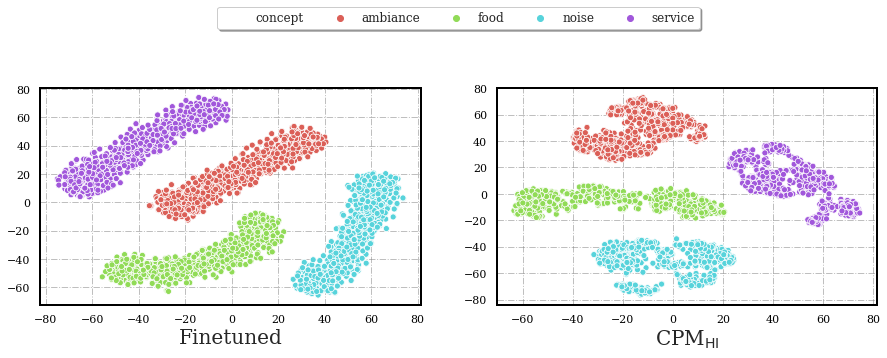

In [36]:
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 20}
plt.rc('font', **font)

with plt.rc_context({
    'axes.edgecolor':'black', 'xtick.color':'black', 
    'ytick.color':'black', 'figure.facecolor':'white'
}):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    sns_g = sns.scatterplot(
        ax=axs[1],
        x="comp1", y="comp2", hue='concept',
        palette=sns.color_palette("hls", 4),
        data=df_tsne, alpha=1,
    )
    sns_g.legend(loc='upper center', bbox_to_anchor=(-0.1, 1.4),
                 ncol=5, fancybox=True, shadow=True, fontsize=12, facecolor="white")
    axs[1].spines["top"].set_linewidth(2)
    axs[1].spines["bottom"].set_linewidth(2)
    axs[1].spines["left"].set_linewidth(2)
    axs[1].spines["right"].set_linewidth(2)
    axs[1].spines["top"].set_linewidth(2)
    axs[1].spines["bottom"].set_linewidth(2)
    axs[1].spines["left"].set_linewidth(2)
    axs[1].spines["right"].set_linewidth(2)
    axs[1].xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    axs[1].yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    axs[1].set_facecolor("white")
    axs[1].set_xlabel(r'CPM$_{\rm HI}$', fontsize=20)
    axs[1].set_ylabel("")
    
    sns_g = sns.scatterplot(
        ax=axs[0],
        x="comp1", y="comp2", hue='concept',
        palette=sns.color_palette("hls", 4),
        data=control_df_tsne, alpha=1, legend=False
    )
    axs[0].spines["top"].set_linewidth(2)
    axs[0].spines["bottom"].set_linewidth(2)
    axs[0].spines["left"].set_linewidth(2)
    axs[0].spines["right"].set_linewidth(2)
    axs[0].spines["top"].set_linewidth(2)
    axs[0].spines["bottom"].set_linewidth(2)
    axs[0].spines["left"].set_linewidth(2)
    axs[0].spines["right"].set_linewidth(2)
    axs[0].xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    axs[0].yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    axs[0].set_facecolor("white")
    axs[0].set_xlabel("Finetuned", fontsize=20)
    axs[0].set_ylabel("")
    
    # plt.savefig("./figures/t-SNE.png",dpi=200, bbox_inches='tight')
    